In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import time
import timeit
import datetime
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import http.client
import requests
import json
import yfinance as yf
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import *
import planarity
from sklearn.linear_model import LinearRegression
import scipy as sc
import math
import random
import yfinance.shared as shared

#!pip install finta
from finta import TA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
import weight_funcs as wf
import pca_graph_funcs as pf

##### Data $-$ Components

In [3]:
# current components
cur_components_df = pd.read_excel('SP500 current components.xlsx')
# changes since 2015 June
changes_df = pd.read_excel('SP500 changes.xlsx',index_col='Date')
changes_df = changes_df.iloc[:176,:]
# components mark from 2015-07-01 to 2022-11-01
components_mark_df = pd.read_csv('components_mark_df.csv',index_col='date')
# all_stocks = list(components_mark_df.columns)
# components_price
adj_close = pd.read_excel("prices.xlsx",index_col='Date')
components_price_df = adj_close.iloc[:-1,:] # delete the last row of NaN (2022-11-01)
components_price_df

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,36.908508,25.817669,36.913132,153.844833,28.721489,49.622807,95.310448,66.160004,43.023254,NaN,...,57.879032,48.939899,21.263666,33.470612,NaN,57.293518,100.078247,112.809998,27.203722,46.070465
2015-07-02,37.209347,25.887632,37.131943,153.334045,28.685190,49.405518,94.770668,65.209999,42.927696,NaN,...,58.420086,48.608845,21.024750,33.397869,NaN,57.206024,99.143532,112.430000,26.820574,45.956310
2015-07-06,37.002518,25.724380,37.797897,154.573166,28.585369,49.412754,95.593605,65.699997,43.214405,NaN,...,57.991467,49.025040,20.965025,32.961414,NaN,56.656151,99.693375,111.839996,26.556625,46.041939
2015-07-07,37.406765,25.794348,38.692188,154.677155,28.515038,49.659042,96.124527,65.680000,43.622742,NaN,...,58.230366,49.356102,21.064568,33.079613,NaN,56.168770,100.591400,112.320000,26.003183,45.547272
2015-07-08,36.429058,24.488304,37.398338,151.328812,27.807211,49.007156,95.416626,64.389999,42.788681,NaN,...,57.597961,48.466957,20.447365,32.343105,NaN,54.437893,98.914429,108.470001,25.330542,44.215473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,134.500000,41.384937,14.290000,181.399994,152.087708,149.820007,152.301620,264.290009,97.949997,NaN,...,105.034447,30.309999,13.680000,97.958382,NaN,110.732498,110.730003,274.579987,51.093529,151.977081
2022-10-26,137.690002,42.542000,14.000000,181.809998,149.102661,152.509995,154.215729,268.250000,98.419998,NaN,...,106.284386,30.879999,14.480000,98.806114,NaN,111.757797,112.269997,273.179993,49.992508,151.348404
2022-10-27,136.490005,41.305138,13.970000,188.080002,144.560196,153.500000,155.422012,267.579987,96.930000,NaN,...,106.691116,30.510000,14.670000,100.282173,NaN,113.390320,111.559998,275.290009,49.972668,150.819534


## (Section 1) Functions

### (1-1) PCA Functions

You can check functions' detail in pca_graph_func.py file

In [4]:
from pca_graph_funcs import feature_generate,merge_df,pca_df, PCA_distance,stock_pool,temp_ohlc,PCA_past_testPCA

### (1-2) Graph filtering, centrality-based stocks selection

In [5]:
from pca_graph_funcs import unfiltered_graph_from_PCA,PMFG,MST,WTA,SS,SS_WTA
from pca_graph_funcs import graph_filter,centrality_sort,centrality_select

### (1-3) Weights

You can check functions' detail in weight_func.py file

In [6]:
from weight_funcs import weight_equal,weight_low_vol,weight_price, weight

Given start_date,end_date and other parameters, generate corresponding results

In [33]:
def weight_generation(start, end, PCA_window=3, holding_period=1, weight_method='equal', filter_mtd='PMFG',
                      selection_way='interval',num_stocks =30, central_method = 'distance', 
                      components_mark_df=components_mark_df, components_price_df=components_price_df):
    # input: start, end (datetime) 
    # must make sure the data before start date is enough to conduct PCA analysis
    #        PCA_window (3m/6m/12m), 
    #        holding_period(1m/3m), 
    #        weight_method('equal','low_vol','markowitz','cap'),
    #        graph_filter ('PMFG','MST','WTA_value',''WTA_proportion'')
    #        central_method ('distance','degree')
    #.       selection_way ('top', 'bottom', 'random', 'interval')
    # replicate the components table, change the values to position in our portfolio
    # output the P_weight to fit the backtest
    w = pd.DataFrame(0, index=components_price_df[start:end].index, columns=components_price_df.columns)
    time_pos = start 
    while time_pos < end:
        pca_end = start
        G0, rel_mat = unfiltered_graph_from_PCA(pca_end,PCA_window,components_mark_df,components_price_df)
        G1 = graph_filter(G0,rel_mat,filter_mtd)
        selected_stocks = centrality_select(G1,central_method, num_stocks ,selection_way)
        
        wt = weight(time_pos, selected_stocks, components_price_df, weight_method)
        for idx in wt.index:
            time_pos_end = time_pos+relativedelta(months=holding_period)
            w.loc[time_pos:time_pos_end,idx] = wt[idx]

        time_pos = time_pos+relativedelta(months=holding_period)
    return w

Find first date of every month from 2017 to 2022

In [8]:
dateindex_new = []
year_prev, month_prev = 0, 0
for date in components_price_df.index:
    if date.year >= 2017:
        if ((date.year != year_prev) or (date.month != month_prev)):
            dateindex_new.append(date)
            year_prev = date.year
            month_prev = date.month
dateindex_new = pd.to_datetime(dateindex_new)

Calculate tracking error and portfolio value

In [15]:
def back_test(P_weight, components_price_df):
    # Back test the portfolio based on the components' weight
    # P_weight: the weight of the portfolio's components
    # components_price_df: the time series of the components price
    # Return: the time series of this portfolio's value
    
    Portfolio = pd.Series(dtype = float)
    dateindex_new = []
    year_prev, month_prev = 0, 0
    for date in components_price_df.index:
        if date.year >= 2017:
            if ((date.year != year_prev) or (date.month != month_prev)):
                dateindex_new.append(date)
                year_prev = date.year
                month_prev = date.month
    dateindex_new = pd.to_datetime(dateindex_new)

    for date in list(P_weight.index):
        # find the first date of this month, the rank data is available on this date.
        prev_date = 0
        for temp_date in dateindex_new:
            if temp_date <= date:
                prev_date = temp_date
            else:
                break
        
        Portfolio[date] = np.nansum(P_weight.loc[prev_date]*components_price_df.loc[date])

    return Portfolio

def tracking_error(Portfolio_return, bench_return):
    # Calculate the tracking error between the portfolio and benchmark
    # Portfolio_return: the time series of the portfolio's return
    # bench_return: the time series of the index return
    days = len(bench_return)
    scale = np.sqrt(252/days)
    return np.std(Portfolio_return-bench_return)*scale*100

Compare our portfolio with SPY etf

In [16]:
def comparison(weight, start, end, price_df=components_price_df, additional_comments=''):
#     portfolio = back_test(weight, price_df.loc[start:end-timedelta(days=1)])
    portfolio = back_test(weight, price_df.loc[start-timedelta(days=1):])
    Portfolio_return = portfolio.pct_change().dropna()
    # Since we have to trade every month, the value of our portfolio may change,
    # So I simply set our return change at each month be 0.0
    for date in dateindex_new:
        if date in Portfolio_return.index:
            Portfolio_return[date] = 0.0
    spy = yf.download('SPY', start, end)['Adj Close']
    SPY_return = spy.pct_change().dropna()
    track_error = tracking_error(Portfolio_return, SPY_return)
    plt.plot(Portfolio_return.index, Portfolio_return,label='Portfolio')
    plt.plot(SPY_return.index, SPY_return, label = 'S&P 500 Benchmark')
    plt.legend()
    plt.title(f'Tracking error is {track_error:.2f}  '+ additional_comments)
    plt.ylabel('return')
    plt.xlabel('date')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

Compare our portfolio with OEF 

In [31]:
# OEF is iShares S&P 100 ETF
# https://www.ishares.com/us/products/239723/ishares-sp-100-etf#/
def compare_OEF(weight, start, end, price_df=components_price_df, additional_comments=''):
    portfolio = back_test(weight, price_df.loc[start:])
    Portfolio_return = portfolio.pct_change().dropna()
    # Since we have to trade every month, the value of our portfolio may change,
    # So I simply set our return change at each month be 0.0
    for date in dateindex_new:
        if date in Portfolio_return.index:
            Portfolio_return[date] = 0.0
    oef = yf.download('OEF', start, end)['Adj Close']
    OEF_return = oef.pct_change().dropna()
    track_error = tracking_error(Portfolio_return, OEF_return)
    plt.plot(Portfolio_return.index, Portfolio_return,label='Portfolio')
    plt.plot(OEF_return.index, OEF_return, label = 'S&P 500 Benchmark(OEF)')
    plt.legend()
    plt.title(f'Tracking error is {track_error:.2f}  ')
    plt.ylabel('return')
    plt.xlabel('date')
    plt.xticks(rotation=45)
    plt.grid()
    plt.savefig(additional_comments,dpi=300)
    plt.show()
    

Compare two benchmarks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


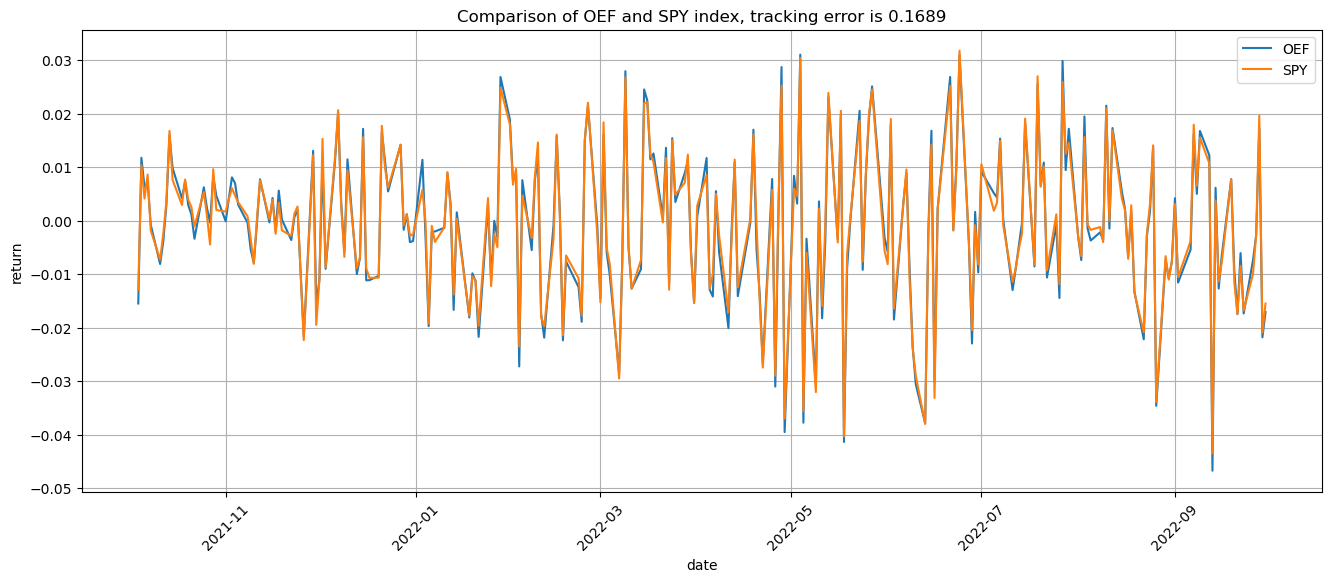

In [18]:
s1=pd.to_datetime('2021-10-01')
s2=pd.to_datetime('2022-10-01')

SPY=yf.download('SPY', s1, s2)['Adj Close']
SPY_return = SPY.pct_change().dropna()
OEF = yf.download('OEF',s1,s2)['Adj Close']
OEF_return  = OEF.pct_change().dropna()

te =  tracking_error(OEF_return, SPY_return)
plt.figure(figsize=(16,6))
plt.plot(OEF_return.index, OEF_return,label='OEF')
plt.plot(SPY_return.index, SPY_return, label = 'SPY')
plt.legend()
plt.title(f'Comparison of OEF and SPY index, tracking error is {te:.4f}')
plt.ylabel('return')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('compare.png',dpi=300)
plt.show()

### We use the following methods to do backtest and plots

In [36]:
s1 = pd.to_datetime('2022-06-01')
s2 = pd.to_datetime('2022-09-01')
w1 = weight_generation(s1,s2,weight_method='equal',selection_way='top',num_stocks=50)

[*********************100%***********************]  499 of 499 completed

1 Failed download:
- NLSN: No data found, symbol may be delisted
[*********************100%***********************]  499 of 499 completed

1 Failed download:
- NLSN: No data found, symbol may be delisted
[*********************100%***********************]  499 of 499 completed

1 Failed download:
- NLSN: No data found, symbol may be delisted


[*********************100%***********************]  1 of 1 completed


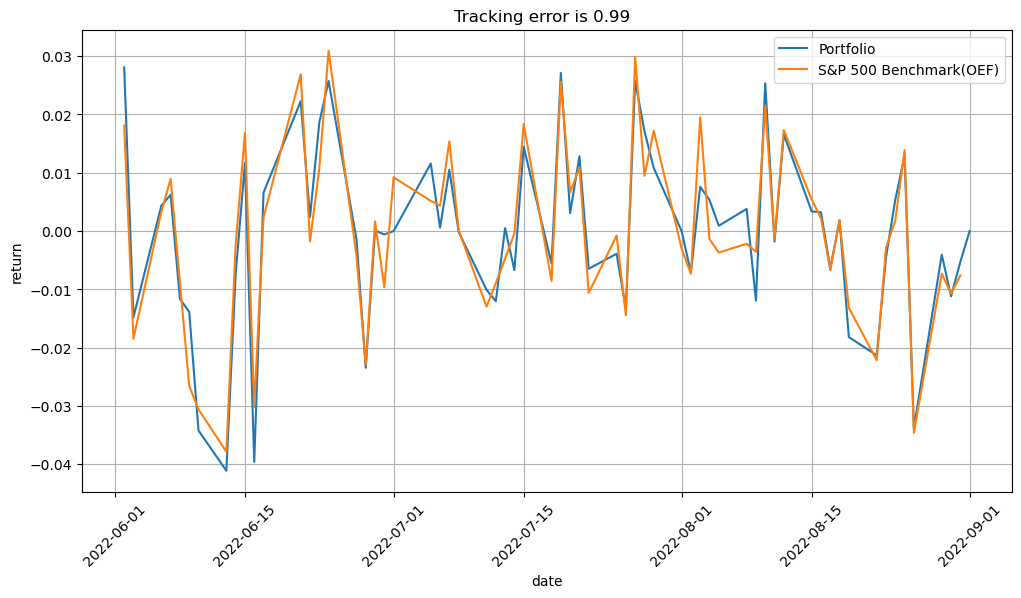

In [37]:
plt.figure(figsize=(12,6))
compare_OEF(w1,s1,s2,additional_comments='test.png')

### Test following parameters

In [14]:
PCA_windows=[3,6] 
holding_period=1
weights=['equal','markowitz','low_vol','price','return']
filters=['PMFG','MST']
selections=['top','bottom','random']
num_stocks =[30,50,100] 
centrals = ['distance']

In [ ]:
start = pd.to_datetime('2022-09-01')
end = pd.to_datetime('2022-10-01')
weight = weight_generation(start, end, )

In [ ]:
compare_OEF(weight,start,end,additional_comments='save this plot.png')